# Testing
### Gebäudebestand nach Gebäudeart, Bauperiode und Stadtquartier, seit 2008
Datum: 03.02.2022

### Importiere die notwendigen Packages

In [ ]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [148]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [149]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [150]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [151]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=4, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=35, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [152]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_geb_jahr_gebart_bauperiode_quartier_od5087

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_best_geb_jahr_gebart_bauperiode_quartier_od5087


In [153]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int";
print(status)

int


In [154]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_best_geb_jahr_gebart_bauperiode_quartier_od5087/download/BAU508OD5087.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_best_geb_jahr_gebart_bauperiode_quartier_od5087\BAU508OD5087.csv"   

print(fp)

\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_best_geb_jahr_gebart_bauperiode_quartier_od5087\BAU508OD5087.csv


In [155]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['Jahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [156]:
#data2betested.head(6)

In [157]:
data2betested.dtypes

Jahr                      datetime64[ns]
QuarSort                           int64
QuarLang                          object
KreisSort                          int64
KreisLang                         object
GebaeudeartLevel1Sort            float64
GebaeudeartLevel1Name             object
GebaeudeartLevel2Sort              int64
GebaeudeartLevel2Name             object
GebaeudeartLevel3Sort              int64
GebaeudeartLevel3Name             object
GebaeudeartLevel4Sort              int64
GebaeudeartLevel4Name             object
GebaeudeartSpezialSort             int64
GebaeudeartSpezialName            object
BauperiodeSort                     int64
BauperiodeName                    object
AnzGbd                             int64
Rauminhalt                         int64
Grundflaeche                       int64
dtype: object

In [158]:
data2betested.shape

(75460, 20)

Beschreibe einzelne Attribute

In [159]:
data2betested.describe()

,QuarSort,KreisSort,GebaeudeartLevel1Sort,GebaeudeartLevel2Sort,GebaeudeartLevel3Sort,GebaeudeartLevel4Sort,GebaeudeartSpezialSort,BauperiodeSort,AnzGbd,Rauminhalt,Grundflaeche
count,75460,75460,75460,75460,75460,75460,75460,75460,75460,75460,75460
mean,70,7,1215,1215,121,12,6,5,10,34194,2040
std,35,3,60,60,6,0,3,3,29,97945,5303
min,11,1,1110,1110,111,11,1,1,1,5,0
25%,41,4,1130,1130,113,11,3,3,1,1374,130
50%,72,7,1242,1242,124,12,6,5,2,4922,435
75%,101,10,1263,1263,126,12,8,8,7,22300,1521
max,123,12,1274,1274,127,12,10,12,482,8113799,81492


Wie viele Nullwerte gibt es im Datensatz?

In [160]:
data2betested.isnull().sum()

Jahr                      0
QuarSort                  0
QuarLang                  0
KreisSort                 0
KreisLang                 0
GebaeudeartLevel1Sort     0
GebaeudeartLevel1Name     0
GebaeudeartLevel2Sort     0
GebaeudeartLevel2Name     0
GebaeudeartLevel3Sort     0
GebaeudeartLevel3Name     0
GebaeudeartLevel4Sort     0
GebaeudeartLevel4Name     0
GebaeudeartSpezialSort    0
GebaeudeartSpezialName    0
BauperiodeSort            0
BauperiodeName            0
AnzGbd                    0
Rauminhalt                0
Grundflaeche              0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [161]:
data2betested = data2betested.set_index("Jahr")

In [162]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75460 entries, 2008-01-01 to 2021-01-01
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   QuarSort                75460 non-null  int64  
 1   QuarLang                75460 non-null  object 
 2   KreisSort               75460 non-null  int64  
 3   KreisLang               75460 non-null  object 
 4   GebaeudeartLevel1Sort   75460 non-null  float64
 5   GebaeudeartLevel1Name   75460 non-null  object 
 6   GebaeudeartLevel2Sort   75460 non-null  int64  
 7   GebaeudeartLevel2Name   75460 non-null  object 
 8   GebaeudeartLevel3Sort   75460 non-null  int64  
 9   GebaeudeartLevel3Name   75460 non-null  object 
 10  GebaeudeartLevel4Sort   75460 non-null  int64  
 11  GebaeudeartLevel4Name   75460 non-null  object 
 12  GebaeudeartSpezialSort  75460 non-null  int64  
 13  GebaeudeartSpezialName  75460 non-null  object 
 14  BauperiodeSort       

Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [163]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [164]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarLang,KreisSort,KreisLang,GebaeudeartLevel1Sort,GebaeudeartLevel1Name,GebaeudeartLevel2Sort,...,GebaeudeartSpezialSort,GebaeudeartSpezialName,BauperiodeSort,BauperiodeName,AnzGbd,Rauminhalt,Grundflaeche
Jahr,,,,,,,,,,,,,,,
2009-01-01,11,Rathaus,1,Kreis 1,1110,Einfamilienhaus freistehend,1110,...,1,Einfamilienhäuser,1,Vor 1893,1,265,53
2009-01-01,11,Rathaus,1,Kreis 1,1110,Einfamilienhaus angebaut,1110,...,1,Einfamilienhäuser,1,Vor 1893,16,13746,1285


### Visualisierungen nach Zeitausschnitten

#### Entwicklung des Gebäudebestands nach Gebäudeart Level 2 seit 2008

In [165]:
#data2betested.dtypes

In [166]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2008":"2021"]\
    .groupby(['Jahr', 'GebaeudeartLevel2Name']) \
    .agg(sum_AnzGbd=('AnzGbd', 'sum'), sum_Rauminhalt=('Rauminhalt', 'sum'), sum_Grundflaeche=('Grundflaeche', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index()
#myAgg.reset_index().melt()

,Jahr,GebaeudeartLevel2Name,sum_AnzGbd,sum_Rauminhalt,sum_Grundflaeche
0,2008-01-01,Andere Gebäude für kurzfristige Beherbergung,99,219883,14103
1,2008-01-01,Wohngebäude für Gemeinschaften,337,2249116,142818
2,2008-01-01,Sporthallen,401,2152613,197704
3,2008-01-01,Sonstige Hochbauten,4767,1530588,153372
4,2008-01-01,"Schul- und Hochschulgebäude, Forschungseinrich...",810,9192347,562171
...,...,...,...,...,...
276,2021-01-01,"Behälter, Silos, Lagergebäude",443,1700414,131726
277,2021-01-01,Andere Gebäude für kurzfristige Beherbergung,187,771105,41070
278,2021-01-01,Sporthallen,387,2093023,196050
279,2021-01-01,Gross- und Einzelhandelsgebäude,407,1768629,110695


In [167]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['GebaeudeartLevel2Name'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_AnzGbd > 1'), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzGbd', axis=alt.Axis(title='Anz. Gebäude'))
    , color=alt.Color('GebaeudeartLevel2Name', legend=alt.Legend(title="Gebäudearten", orient="right"))  
    ,tooltip=['Jahr', 'GebaeudeartLevel2Name','sum_AnzGbd']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [170]:
#data2betested.dtypes

In [172]:
myAggBar = data2betested.loc["2021"]\
    .groupby(['Jahr', 'GebaeudeartSpezialName']) \
    .agg(sum_AnzGbd=('AnzGbd', 'sum'), sum_Rauminhalt=('Rauminhalt', 'sum'), sum_Grundflaeche=('Grundflaeche', 'sum')) \
    .sort_values('sum_Rauminhalt', ascending=True) 

#myAggBar.reset_index().dtypes


In [173]:
#help(sns.catplot)     

In [174]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

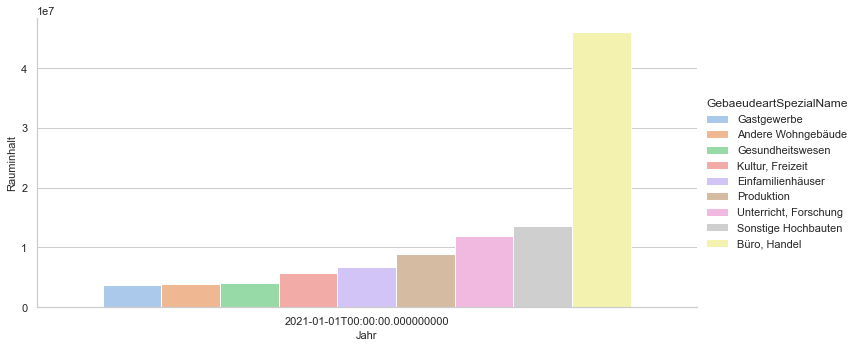

In [175]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_Rauminhalt"
            , hue="GebaeudeartSpezialName"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.query("GebaeudeartSpezialName !='Mehrfamilienhäuser'").reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Rauminhalt', fontsize=11)


In [181]:
data2betested.dtypes

QuarSort                    int64
QuarLang                   object
KreisSort                   int64
KreisLang                  object
GebaeudeartLevel1Sort     float64
GebaeudeartLevel1Name      object
GebaeudeartLevel2Sort       int64
GebaeudeartLevel2Name      object
GebaeudeartLevel3Sort       int64
GebaeudeartLevel3Name      object
GebaeudeartLevel4Sort       int64
GebaeudeartLevel4Name      object
GebaeudeartSpezialSort      int64
GebaeudeartSpezialName     object
BauperiodeSort              int64
BauperiodeName             object
AnzGbd                      int64
Rauminhalt                  int64
Grundflaeche                int64
dtype: object

##### Entwicklung der Anzahl projektierter Wohnungen pro Kreis nach Eigentumsart

In [189]:
myAggBar = data2betested.loc["2008":"2021"]\
    .groupby(['Jahr', 'GebaeudeartLevel4Name', 'KreisLang']) \
    .agg(sum_AnzGbd=('AnzGbd', 'sum'), sum_Rauminhalt=('Rauminhalt', 'sum'), sum_Grundflaeche=('Grundflaeche', 'sum')) \
    .sort_values('sum_Rauminhalt', ascending=True) 

myAggBar.reset_index().dtypes

Jahr                     datetime64[ns]
GebaeudeartLevel4Name            object
KreisLang                        object
sum_AnzGbd                        int64
sum_Rauminhalt                    int64
sum_Grundflaeche                  int64
dtype: object

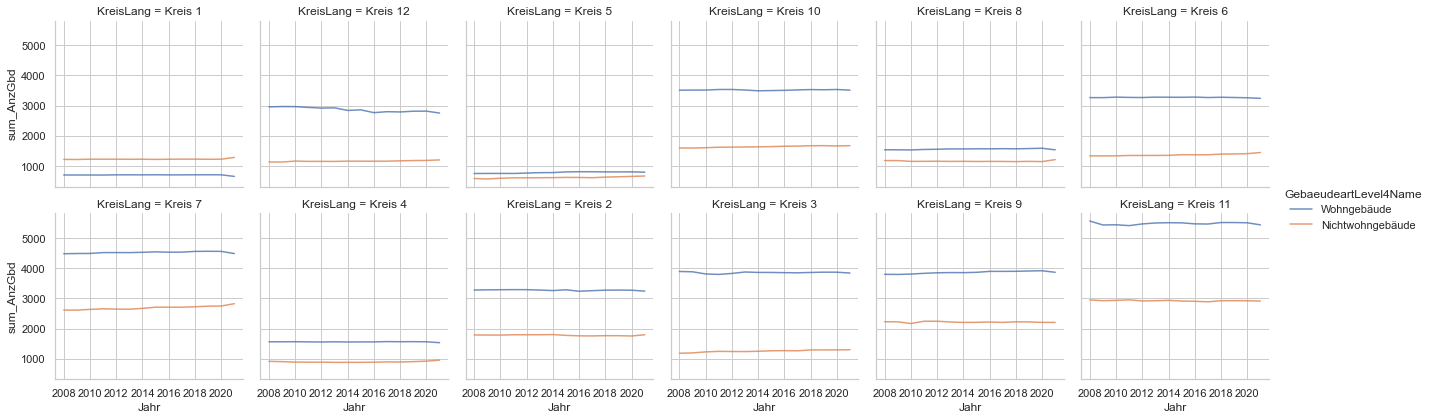

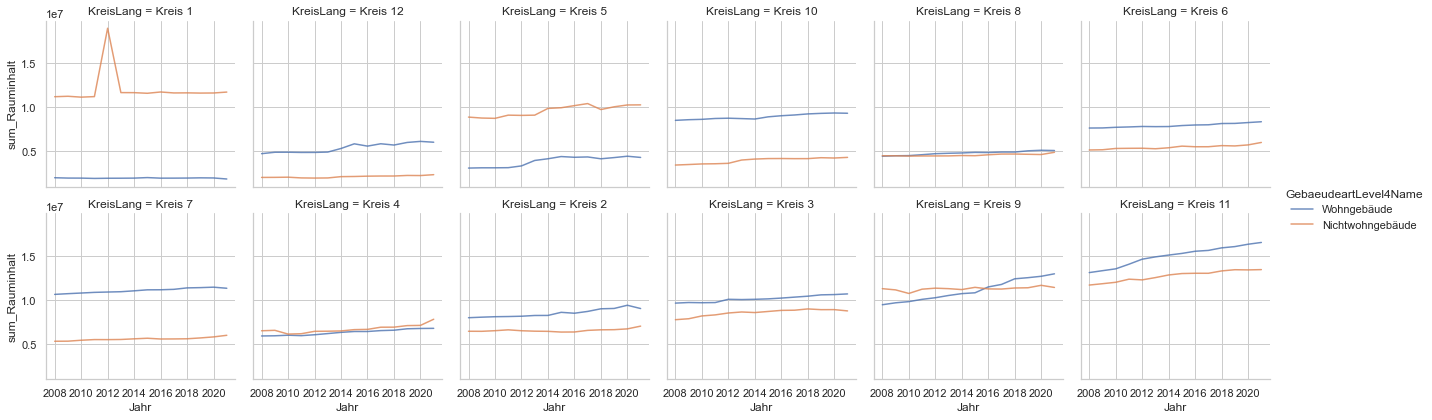

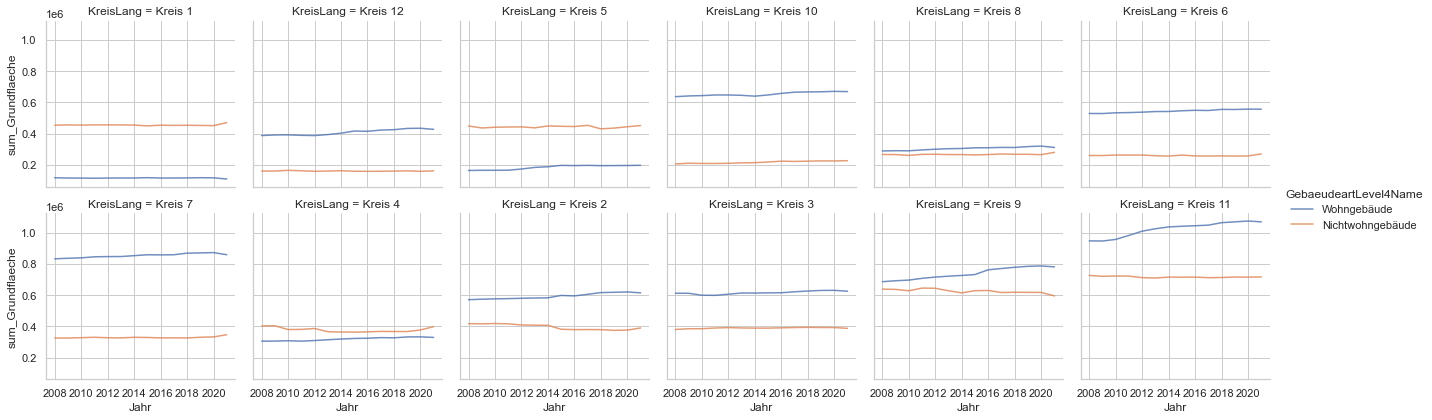

In [190]:
g = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="GebaeudeartLevel4Name", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_AnzWhg", alpha=.8)
g.map(sns.lineplot, "Jahr","sum_AnzGbd", alpha=.8)
g.add_legend()

g2 = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="GebaeudeartLevel4Name", col_wrap=6, height=3,)
g2.map(sns.lineplot, "Jahr","sum_Rauminhalt", alpha=.8)
g2.add_legend()

g3 = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="GebaeudeartLevel4Name", col_wrap=6, height=3,)
g3.map(sns.lineplot, "Jahr","sum_Grundflaeche", alpha=.8)
g3.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Rauminhalt der Gebäude nach Gebäudearten 2021

In [209]:
#data2betested.dtypes

In [210]:
myTreemapAgg = data2betested.loc["2021"]\
    .groupby(['Jahr', 'GebaeudeartLevel4Name','GebaeudeartLevel1Name']) \
    .agg(sum_AnzGbd=('AnzGbd', 'sum'), sum_Rauminhalt=('Rauminhalt', 'sum'), sum_Grundflaeche=('Grundflaeche', 'sum')) \
    .sort_values('sum_Rauminhalt', ascending=True) 

myTreemapAgg.reset_index().dtypes

Jahr                     datetime64[ns]
GebaeudeartLevel4Name            object
GebaeudeartLevel1Name            object
sum_AnzGbd                        int64
sum_Rauminhalt                    int64
sum_Grundflaeche                  int64
dtype: object

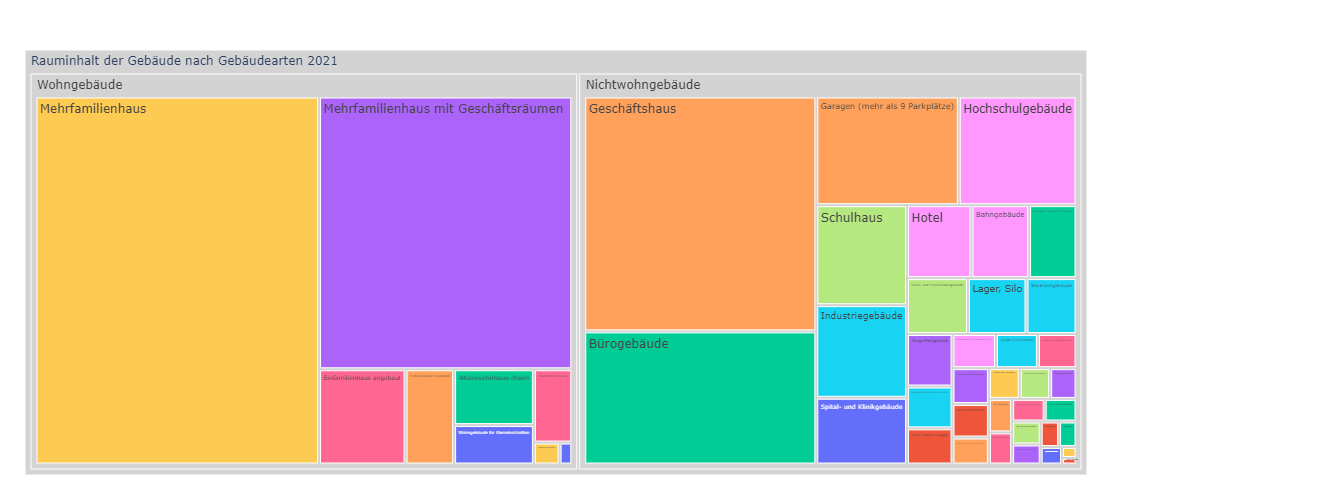

In [211]:
fig = px.treemap(myTreemapAgg.query('sum_AnzGbd >0').reset_index(), path=[px.Constant("Rauminhalt der Gebäude nach Gebäudearten 2021")
                                                                                      ,'GebaeudeartLevel4Name','GebaeudeartLevel1Name']
                 , values='sum_Rauminhalt'
                 , color='GebaeudeartLevel1Name'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1300                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [212]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=635&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [124]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [115]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [119]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

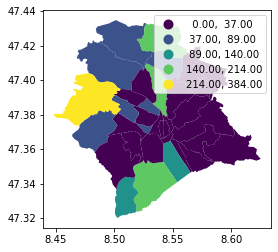

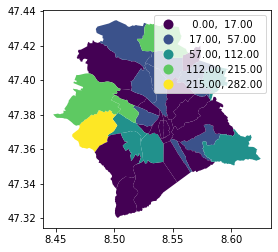

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

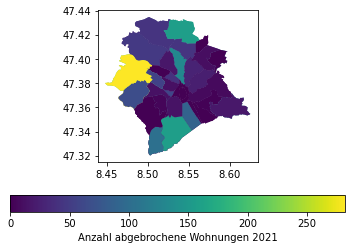

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=636&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**